In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [65]:
import nltk
import statistics
import numpy as np
import pickle as pkl
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import tensorflow as tf
from numpy import mean

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional
from tensorflow.keras.models import Sequential, load_model, model_from_config
import tensorflow.keras.backend as K 
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#from textblob import Word
import nltk
nltk.download('averaged_perceptron_tagger')  

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


False

In [66]:
X=pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
test=pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")

In [67]:
X1_train = X.loc[:int(len(X.index)*0.8)]
y_train = X1_train[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']]
X1_val = X.loc[int(len(X.index)*0.8)+1:int(len(X.index)*0.9)]
y_val = X1_val[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']]
X1_test = X.loc[int(len(X.index)*0.9)+1:]
y_test = X1_test[['syntax','cohesion','vocabulary','phraseology','grammar','conventions']] 

#X1_train is only for extracting out y for each set.

In [68]:
IP=14

y1_train=y_train["syntax"]
y2_train=y_train["cohesion"]
y3_train=y_train["vocabulary"]
y4_train=y_train["phraseology"]
y5_train=y_train["grammar"]
y6_train=y_train["conventions"]

y1_val=y_val["syntax"]
y2_val=y_val["cohesion"]
y3_val=y_val["vocabulary"]
y4_val=y_val["phraseology"]
y5_val=y_val["grammar"]
y6_val=y_val["conventions"]

y1_test=y_test["syntax"]
y2_test=y_test["cohesion"]
y3_test=y_test["vocabulary"]
y4_test=y_test["phraseology"]
y5_test=y_test["grammar"]
y6_test=y_test["conventions"]


y1_train = np.asarray(y1_train)
y1_val = np.asarray(y1_val)  

y2_train = np.asarray(y2_train)
y2_val = np.asarray(y2_val)  

y3_train = np.asarray(y3_train)
y3_val = np.asarray(y3_val)  

y4_train = np.asarray(y4_train)
y4_val = np.asarray(y4_val)  

y5_train = np.asarray(y5_train)
y5_val = np.asarray(y5_val)  

y6_train = np.asarray(y6_train)
y6_val = np.asarray(y6_val)  


In [71]:
def tokenize_sent(essay):
    sent_tokenize = nltk.tokenize.sent_tokenize(essay)
    return sent_tokenize

def count_sentences(essay):
    return len(tokenize_sent(essay))

def tokenize_words(essay):
    word_tokenize = nltk.tokenize.word_tokenize(essay)
    return word_tokenize

    return word_tokens, list(set(word_tokens))

def word_count(essay):
    return len(tokenize_words(essay))

def sentence_length(sent):
    len_of_sent = []
    for s in sent:
        len_of_sent.append(count_sentences(sent))
    return len_of_sent, statistics.mean(len_of_sent)

def avg_word_sentence(data):
        return sentence_length(tokenize_sent(data)[0])[1]
    
def pos_tags(data):
    sent = tokenize_sent(data)[0]
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    adp_count=0
    conj_count = 0
    det_count = 0
    prt_count = 0
    pron_count = 0
    punct_count=0
    
    
    for s in sent:
        tags = nltk.pos_tag(tokenize_words(s))
        #print(tags)
        for tag in tags:
            if tag[1][0] == 'N':
                noun_count += 1
            elif tag[1][0] == 'J':
                adj_count += 1
            elif tag[1][0] == 'V':
                verb_count += 1
            elif tag[1][0] == 'R':
                adv_count += 1
            elif tag[1] == 'IN':
                adp_count += 1
            elif tag[1] == 'CC':
                conj_count += 1
            elif tag[1] == 'DT':
                det_count += 1
            elif tag[1] == 'PRT':
                prt_count += 1
            elif tag[1] == 'PRP' or tag[1] == 'PRP$' :
                pron_count += 1
            elif tag[1] == '.':
                punct_count += 1
                
    return noun_count,adj_count,verb_count,adv_count , adp_count , conj_count, det_count , pron_count , punct_count

In [72]:
X['num_words'] = X['full_text'].apply(word_count)
X


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,283
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,554
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,356
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,836
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,237
...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,189
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,502
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,277
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,560


In [73]:
X['num_sents'] = X['full_text'].apply(count_sentences)
X 

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,num_sents
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,283,18
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,554,14
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,356,19
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,836,36
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,237,3
...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,189,6
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,502,16
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,277,8
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,560,21


In [74]:
X['avg_word_sent'] = X['full_text'].apply(avg_word_sentence)
X

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,num_words,num_sents,avg_word_sent
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,283,18,1
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,554,14,1
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,356,19,1
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,836,36,1
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,237,3,1
...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,189,6,1
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,502,16,1
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,277,8,1
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,560,21,1


In [75]:
X['noun_count'], X['adj_count'], X['verb_count'], X['adv_count'], X['adp_count'],X['conj_count'], X['det_count'], X['pron_count'], X['punct_count']  = zip(*X['full_text'].map(pos_tags))


In [76]:
features = X.iloc[:,8:]
features_array = np.asarray(features)
features_array_train = features_array[:3129]
features_array_val = features_array[3129:3129+391]
features_array_test = features_array[3129+391:]
print(features_array_test.shape)
print(features_array_val.shape)
print(features_array_train.shape)
features


(391, 12)
(391, 12)
(3129, 12)


,num_words,num_sents,avg_word_sent,noun_count,adj_count,verb_count,adv_count,adp_count,conj_count,det_count,pron_count,punct_count
0,283,18,1,111,0,0,0,0,0,10,1,1
1,554,14,1,82,0,0,0,0,0,9,0,1
2,356,19,1,58,0,0,0,0,0,10,1,1
3,836,36,1,40,0,0,0,0,0,0,0,1
4,237,3,1,624,0,0,0,0,0,44,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3906,189,6,1,68,0,0,0,0,0,4,1,1
3907,502,16,1,198,0,0,0,0,0,15,0,1
3908,277,8,1,87,0,0,0,0,0,8,1,1
3909,560,21,1,98,0,0,0,0,0,5,0,1


In [89]:


rf1 = RandomForestRegressor(n_estimators = 100)
rf2= RandomForestRegressor(n_estimators = 100)
rf3 = RandomForestRegressor(n_estimators = 100)
rf4 = RandomForestRegressor(n_estimators = 100)
rf5 = RandomForestRegressor(n_estimators = 100)
rf6 = RandomForestRegressor(n_estimators = 100)

rf1.fit(features_array_train, y1_train)
rf2.fit(features_array_train, y2_train)
rf3.fit(features_array_train, y3_train)
rf4.fit(features_array_train, y4_train)
rf5.fit(features_array_train, y5_train)
rf6.fit(features_array_train, y6_train)



y1_pred = rf1.predict(features_array_test)
y2_pred = rf2.predict(features_array_test)
y3_pred = rf3.predict(features_array_test)
y4_pred = rf4.predict(features_array_test)
y5_pred = rf5.predict(features_array_test)
y6_pred = rf6.predict(features_array_test)

y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

0.37218670076726346


In [78]:
lstm_embed_train = []
for i in range(0,len(features_array_train)):
    lstm_embed_train.append(np.asarray([features_array_train[i]]))
    

lstm_embed_test = []
for i in range(0,len(features_array_test)):
    lstm_embed_test.append(np.asarray([features_array_test[i]]))
     


lstm_embed_val = []
for i in range(0,len(features_array_val)):
    lstm_embed_val.append(np.asarray([features_array_val[i]]))


lstm_embed_test = np.asarray(lstm_embed_test)
lstm_embed_train = np.asarray(lstm_embed_train)
lstm_embed_val = np.asarray(lstm_embed_val)
print(lstm_embed_train.shape)
print(lstm_embed_val.shape)
print(lstm_embed_test.shape) 


(3129, 1, 12)
(391, 1, 12)
(391, 1, 12)


In [79]:
def get_model_lstm():
    
    model = Sequential()
    model.add(LSTM(128, input_shape=[1,12], activation = 'relu',return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    return model

In [80]:
lstm1 = get_model_lstm();
lstm2 = get_model_lstm();
lstm3 = get_model_lstm();
lstm4 = get_model_lstm();
lstm5 = get_model_lstm();
lstm6 = get_model_lstm();

history1=lstm1.fit(lstm_embed_train, y1_train, epochs=100,validation_data=(lstm_embed_val,y1_val))
history2=lstm2.fit(lstm_embed_train, y2_train, epochs=100,validation_data=(lstm_embed_val,y2_val))
history3=lstm3.fit(lstm_embed_train, y3_train, epochs=100,validation_data=(lstm_embed_val,y3_val))
history4=lstm4.fit(lstm_embed_train, y4_train, epochs=100,validation_data=(lstm_embed_val,y4_val))
history5=lstm5.fit(lstm_embed_train, y5_train, epochs=100,validation_data=(lstm_embed_val,y5_val))
history6=lstm6.fit(lstm_embed_train, y6_train, epochs=100,validation_data=(lstm_embed_val,y6_val))

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 128)            72192     
_________________________________________________________________
dropout_36 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
dense_72 (Dense)             (None, 1, 32)             4128      
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_73 (Dense)             (None, 1, 1)              33        
Total params: 76,353
Trainable params: 76,353
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
Layer (type)              

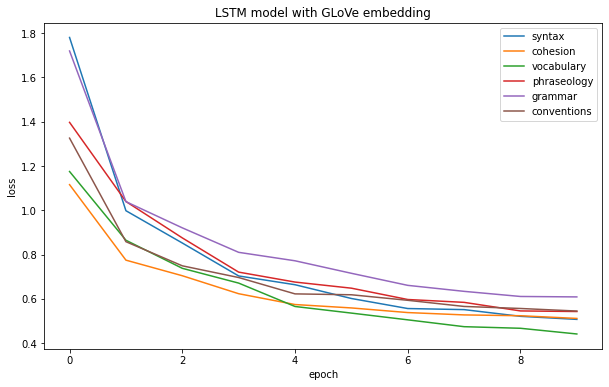

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])

plt.title('LSTM model with GLoVe embedding')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['syntax','cohesion','vocabulary','phraseology','grammar','conventions'])

In [82]:
y1_pred = lstm1.predict(lstm_embed_test).flatten()
y2_pred = lstm2.predict(lstm_embed_test).flatten()
y3_pred = lstm3.predict(lstm_embed_test).flatten()
y4_pred = lstm4.predict(lstm_embed_test).flatten()
y5_pred = lstm5.predict(lstm_embed_test).flatten()
y6_pred = lstm6.predict(lstm_embed_test).flatten()


y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


print(values1,values2,values3,values4,values5,values6)
l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

0.35452685442727816 0.3680051101991926 0.29964195185610404 0.37611252594482397 0.4532225009181696 0.3983120123382761
0.3749701592806407


In [83]:
clf1 = SVR(C=10.0, epsilon=0.01)
clf2 = SVR(C=10.0, epsilon=0.01)
clf3 = SVR(C=10.0, epsilon=0.01)
clf4 = SVR(C=10.0, epsilon=0.01)
clf5 = SVR(C=10.0, epsilon=0.01)
clf6 = SVR(C=10.0, epsilon=0.01)

clf1.fit(features_array_train, y1_train)
clf2.fit(features_array_train, y2_train)
clf3.fit(features_array_train, y3_train)
clf4.fit(features_array_train, y4_train)
clf5.fit(features_array_train, y5_train)
clf6.fit(features_array_train, y6_train)


y1_pred = clf1.predict(features_array_test)
y2_pred = clf2.predict(features_array_test)
y3_pred = clf3.predict(features_array_test)
y4_pred = clf4.predict(features_array_test)
y5_pred = clf5.predict(features_array_test)
y6_pred = clf6.predict(features_array_test)
y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

0.35858056265984656


In [84]:
def get_model_nn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=12, activation='tanh'))
#     model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    print(model.summary())
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])
    return model

In [85]:
embedding_model1 = get_model_nn()
embedding_model2 = get_model_nn()
embedding_model3 = get_model_nn()
embedding_model4= get_model_nn()
embedding_model5 = get_model_nn()
embedding_model6 = get_model_nn()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_85 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 5         
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 260       
_______________________

In [86]:
history11=embedding_model1.fit(features_array_train, y1_train, epochs=100,validation_data=(features_array_val,y1_val))
history22=embedding_model2.fit(features_array_train, y2_train, epochs=100,validation_data=(features_array_val,y2_val))
history33=embedding_model3.fit(features_array_train, y3_train, epochs=100,validation_data=(features_array_val,y3_val))
history44=embedding_model4.fit(features_array_train, y4_train, epochs=100,validation_data=(features_array_val,y4_val))
history55=embedding_model5.fit(features_array_train, y5_train, epochs=100,validation_data=(features_array_val,y5_val))
history66=embedding_model6.fit(features_array_train, y6_train, epochs=100,validation_data=(features_array_val,y6_val))

Epoch 1/10
98/98 [==============================] - 1s 3ms/step - loss: 3.6288 - accuracy: 0.0026 - val_loss: 0.4153 - val_accuracy: 0.0026
Epoch 2/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.0029 - val_loss: 0.3938 - val_accuracy: 0.0026
Epoch 3/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3800 - accuracy: 0.0029 - val_loss: 0.3956 - val_accuracy: 0.0026
Epoch 4/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.0029 - val_loss: 0.3830 - val_accuracy: 0.0026
Epoch 5/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.0029 - val_loss: 0.3904 - val_accuracy: 0.0026
Epoch 6/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3724 - accuracy: 0.0029 - val_loss: 0.3779 - val_accuracy: 0.0026
Epoch 7/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.0029 - val_loss: 0.3778 - val_accuracy: 0.0026
Epoch 8/10
98/98 [==

In [87]:



y1_pred = embedding_model1.predict(features_array_test).flatten()
y2_pred = embedding_model1.predict(features_array_test).flatten()
y3_pred = embedding_model1.predict(features_array_test).flatten()
y4_pred = embedding_model1.predict(features_array_test).flatten()
y5_pred = embedding_model1.predict(features_array_test).flatten()
y6_pred = embedding_model1.predict(features_array_test).flatten()



y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

0.3599531098095084


In [88]:
lr1 = LinearRegression()
lr2 = LinearRegression()
lr3 = LinearRegression()
lr4 = LinearRegression()
lr5 = LinearRegression()
lr6 = LinearRegression()

lr1.fit(features_array_train, y1_train)
lr2.fit(features_array_train, y2_train)
lr3.fit(features_array_train, y3_train)
lr4.fit(features_array_train, y4_train)
lr5.fit(features_array_train, y5_train)
lr6.fit(features_array_train, y6_train)


y1_pred = lr1.predict(features_array_test)
y2_pred = lr2.predict(features_array_test)
y3_pred = lr3.predict(features_array_test)
y4_pred = lr4.predict(features_array_test)
y5_pred = lr5.predict(features_array_test)
y6_pred = lr6.predict(features_array_test)

y1_pred = [round(r,1) for r in y1_pred]
y2_pred = [round(r,1) for r in y2_pred]
y3_pred = [round(r,1) for r in y3_pred]
y4_pred = [round(r,1) for r in y4_pred]
y5_pred = [round(r,1) for r in y5_pred]
y6_pred = [round(r,1) for r in y6_pred]


values1 = mean_squared_error(y1_pred, y1_test)
values2 = mean_squared_error(y2_pred, y2_test)
values3 = mean_squared_error(y3_pred, y3_test)
values4 = mean_squared_error(y4_pred, y4_test)
values5 = mean_squared_error(y5_pred, y5_test)
values6 = mean_squared_error(y6_pred, y6_test)


l=[(values1,values2,values3,values4,values5,values6)]
print(mean(l))

0.3634910485933503
